## Hypothesis
Using batch normalisation helps training by preventing the internal covariate shift and allows for higher learning rates and less careful initialisations.
While it is standard practice to use batch normalisation on all layers, we suspect most of its benefits can be yielded by implementing in only on a subset of the layers.

##Setup

We are going to be testing our hypothesis while training a multi-class classifier on the MNIST dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

# download and transform train dataset
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../../Data/mnist_data', download=True, train=True, transform=transforms.Compose([
transforms.ToTensor(), # first, convert image to PyTorch tensor
transforms.Normalize((0.1307,), (0.3081,)) ])), 
batch_size=128, shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../../Data/mnist_data', download=True, train=False,transform=transforms.Compose([
transforms.ToTensor(), # first, convert image to PyTorch tensor
transforms.Normalize((0.1307,), (0.3081,)) ])), 
batch_size=128, shuffle=True)

Extracting ../../Data/mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ../../Data/mnist_data/MNIST/raw


Extracting ../../Data/mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../Data/mnist_data/MNIST/raw


Extracting ../../Data/mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../Data/mnist_data/MNIST/raw


Extracting ../../Data/mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../Data/mnist_data/MNIST/raw
Processing...
Done!






/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


##Defining the network
We are implementing a convolutional neural network with two convolutional and two fully connected layers. (~LeNet-5)

We achieve the selective batch normalisations by passing a list of booleans to the classifier when initialising, however unelegant of a solution that is :).

In [ ]:
class CNNClassifier(nn.Module):
    normlayers = []
    def __init__(self, normlayers=[True, True, True, True]):
        self.normlayers = normlayers
        
        super(CNNClassifier, self).__init__()
        #two convolutional layers
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2, bias= False)
        if(normlayers[0]):
          self.conv1_bn = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, bias= False)
        if(normlayers[1]):
          self.conv2_bn = nn.BatchNorm2d(32)
        
        #fully connected layers
        self.fc1 = nn.Linear(32*5*5, 120, bias= False)
        if(normlayers[2]):
          self.fc1_bn = nn.BatchNorm1d(120)
        
        self.fc2 = nn.Linear(120, 84, bias= False)
        if(normlayers[3]):
          self.fc2_bn = nn.BatchNorm1d(84)
        
        self.fc3 = nn.Linear(84, 10)
      
           
    def forward(self, x):
                #definition of the forward pass
                x=self.conv1(x)
                if(self.normlayers[0]):
                  x=self.conv1_bn(x)
                x=F.max_pool2d(x, 2 ,2)
                x = F.relu(x)
                
                x=self.conv2(x)
                if(self.normlayers[1]):
                  x=self.conv2_bn(x)
                x=F.max_pool2d(x, 2 ,2)
                x = F.relu(x)
                
                x= x.view(-1,32*5*5)
                
                x=self.fc1(x)
                if(self.normlayers[2]):
                  x=self.fc1_bn(x)
                x = F.relu(x)
                
                x=self.fc2(x)
                if(self.normlayers[3]):
                  x=self.fc2_bn(x)
                x = F.relu(x)
                
                x=self.fc3(x)
                
                
                return F.log_softmax(x,-1)

In [ ]:
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
criterion1 = nn.CrossEntropyLoss()

# a cosmetic function for compulsive reasons, skip
def pad(num, l):
  s = str(num)[:l]
  return(s + ' ' * (l - len(s)))

In [ ]:
def train(epoch):
    #training for one epoch
    #reading data
    for batch_id, (data, label) in enumerate(train_loader):
        clf.train() #set the net to train mode
        data=data.cuda() #put data on gpu
        label=label.cuda()
        opt.zero_grad()
        preds = clf(data) #execute forward pass
        #calculate loss
        loss = torch.diag(preds[:,label])
        loss =  -torch.mean(loss)
        loss.backward() #backward pass
        train_loss_history[-1].append(loss.item())
        opt.step() #update parameters
        #calculate accuracy
        predind = preds.data.max(1)[1] 
        acc = predind.eq(label.data).cpu().float().mean() 
        train_acc_history[-1].append(acc)
        
        if batch_id % 100 == 0:
            metrics = "Train Loss: " + pad(loss.item(), 7) + " Acc: " + pad(acc.item(), 4)

            #run independent test
            clf.eval() # set model in inference mode (need this because of dropout)
            test_loss = 0
            correct = 0
        
            for data, target in test_loader: 
                data=data.cuda()
                target=target.cuda()  
                with torch.no_grad():    
                   output = clf(data)
                   test_loss += F.nll_loss(output, target).item()
                   pred = output.data.max(1)[1] 
                   correct += pred.eq(target.data).cpu().sum()

            test_loss = test_loss
            test_loss /= len(test_loader) # loss function already averages over batch size
            accuracy =  correct.item() / len(test_loader.dataset)
            test_acc_history[-1].append(accuracy)
            test_loss_history[-1].append(test_loss)
            metrics += "  |  Test Loss: " + pad(test_loss, 7) + " Acc: " + pad(accuracy, 4)
            print(metrics)

In [ ]:
# execute training N times, with normalizations where specified
# this is the training procedure as opposed to a single training step
# (I tend to be bad with naming functions.)
def run_training(N=10, normlayers=[True, True, True, True]):
  global clf, opt
  for repeat in range(0, 1):
      clf = CNNClassifier(normlayers)
      clf.cuda()
      opt = optim.SGD(clf.parameters(), lr=0.01, momentum=0.5)
      train_loss_history.append([])
      train_acc_history.append([])
      test_loss_history.append([])
      test_acc_history.append([])
      for epoch in range(0, N):
          print("Epoch %d" % epoch)
          train(epoch)

##The experiment
Here we have a few subsets of the 2^4 possible boolean lists. We define the experiment function which allows us to compare training processes by specifying a subset of all possible settings and the number of epochs to train (this is to moderate the length of experiments when training many networks).

In [ ]:
# arrays of settings to use later
all_binaries = [[False, False, False, False],
            [False, False, False, True],
            [False, False, True, False],
            [False, True, False, False],
            [True, False, False, False],
            [False, False, True, True],
            [False, True, False, True],
            [True, False, False, True],
            [False, True, True, False],
            [True, False, True, False],
            [True, True, False, False],
            [False, True, True, True],
            [True, False, True, True],
            [True, True, False, True],
            [True, True, True, False],
            [True, True, True, True]]
            
selection = [[False, False, False, False],
            [False, True, False, False],
            [False, True, True, False],
            [True, False, True, False],
            [True, True, False, False],
            [True, True, True, True]]

extremes = [[False, False, False, False],
            [True, True, True, True]]
             

In [ ]:
# train the network with a specific set of normalisation settings, for N epochs each.
def experiment(epochs, norm_settings):
  for list in norm_settings:
    print('\nTraining with ' + str(list))
    run_training(epochs, list)

In [ ]:
test_acc_history = []
experiment(2, selection)


Training with [False, False, False, False]
Epoch 0
Train Loss: 2.31195 Acc: 0.10  |  Test Loss: 2.30621 Acc: 0.09
Train Loss: 2.23598 Acc: 0.28  |  Test Loss: 2.23475 Acc: 0.27
Train Loss: 1.03036 Acc: 0.73  |  Test Loss: 0.97455 Acc: 0.76
Train Loss: 0.52927 Acc: 0.81  |  Test Loss: 0.40844 Acc: 0.87
Train Loss: 0.17610 Acc: 0.92  |  Test Loss: 0.31698 Acc: 0.90
Epoch 1
Train Loss: 0.22235 Acc: 0.91  |  Test Loss: 0.29272 Acc: 0.90
Train Loss: 0.34429 Acc: 0.88  |  Test Loss: 0.20466 Acc: 0.93
Train Loss: 0.27018 Acc: 0.92  |  Test Loss: 0.18456 Acc: 0.94
Train Loss: 0.26085 Acc: 0.92  |  Test Loss: 0.15406 Acc: 0.95
Train Loss: 0.20992 Acc: 0.94  |  Test Loss: 0.13034 Acc: 0.96

Training with [False, True, False, False]
Epoch 0
Train Loss: 2.30480 Acc: 0.07  |  Test Loss: 2.30120 Acc: 0.12
Train Loss: 0.81323 Acc: 0.87  |  Test Loss: 0.83194 Acc: 0.86
Train Loss: 0.29141 Acc: 0.92  |  Test Loss: 0.28407 Acc: 0.93
Train Loss: 0.19794 Acc: 0.93  |  Test Loss: 0.17746 Acc: 0.95
Train L

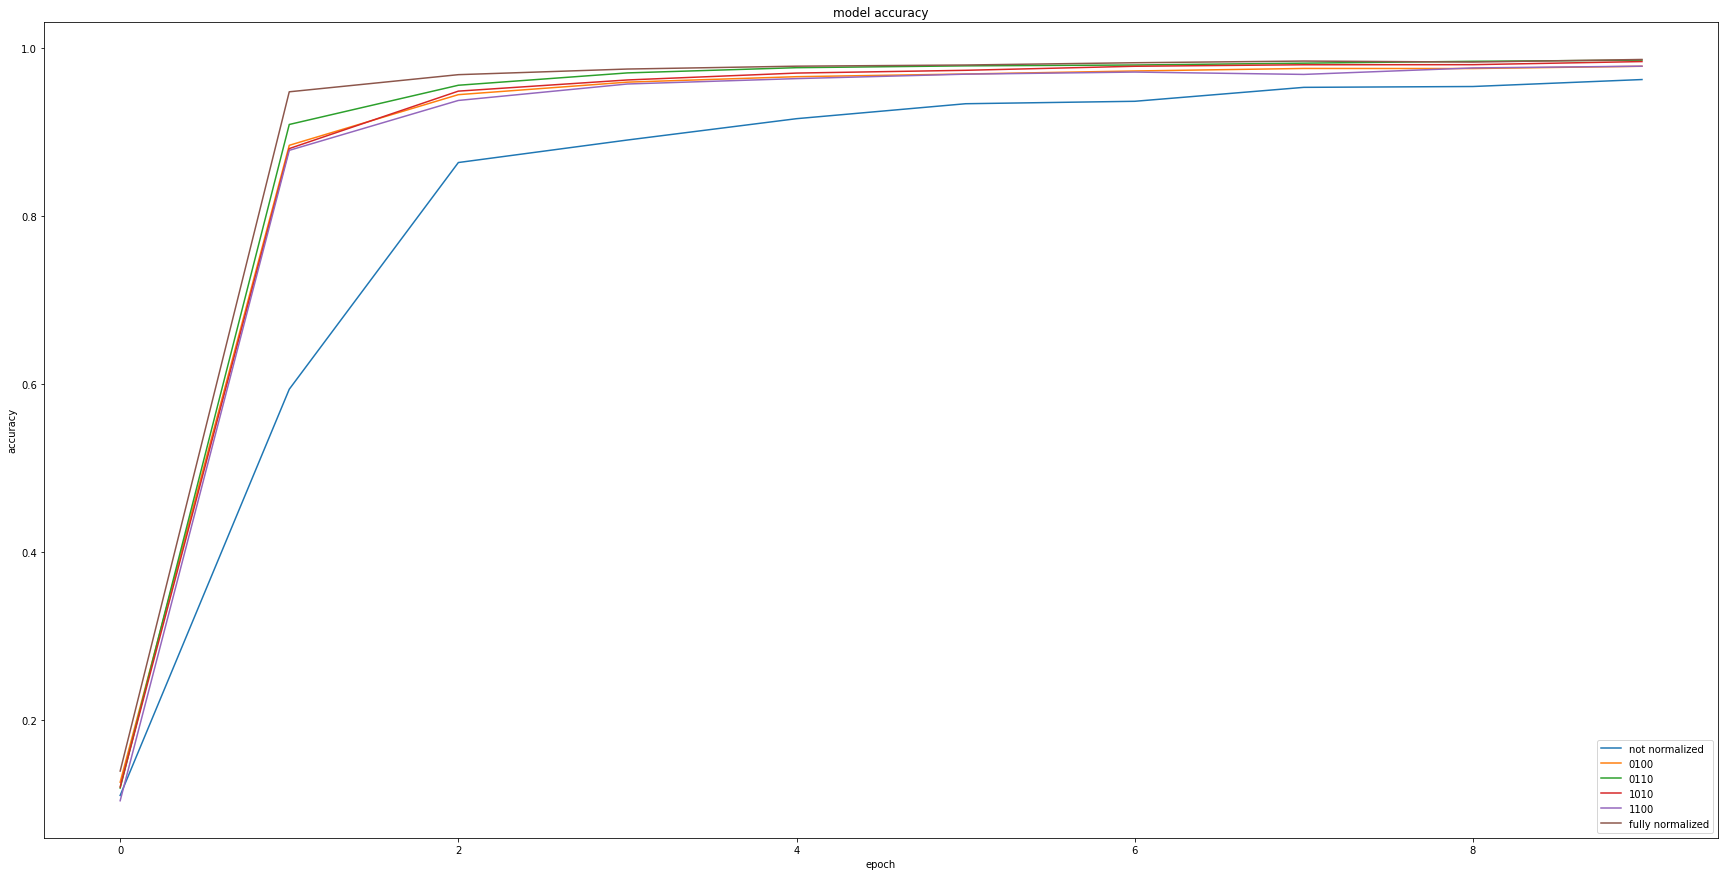

In [ ]:
plt.rcParams['figure.figsize'] = (30,15)
for a in test_acc_history:
  plt.plot(range(len(a)), a)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['not normalized', '0100', '0110', '1010', '1100', 'fully normalized'], loc='lower right')
plt.show()

##Conclusion

We can see that by normalising just 1 of 4 layers, we can obtain much of the benefits (~75%) of a fully normalised network in the early training steps. Naturally, the results improve further when normalising 2.
The most efficient setting seems to be the [False, True, True, False] one, that is, when applying batch norm in the middle layers.

![Plot](https://drive.google.com/uc?id=1k9DUxCcOHq2hBStiAiZsRS5-C-t7Oa-x)
